# Project Milestone 2

# Left click, Right click : A Safari Through Wikispeedia's Political Jungle

## Import Libraries 

In [1]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
from bs4 import BeautifulSoup 
import os
from Functions import *
import numpy as np

## Download the data and extract it

In [2]:
download_extract_data() #Put the data in the data folder that is ignored to github push

Repository data already exist
./data/wikispeedia_paths-and-graph.tar.gz downloaded
./data/wikispeedia_articles_plaintext.tar.gz downloaded


## Load and Filter of the used data

### Finished and Unfinished Path

In [3]:
#define paths
PATH_FINISHED="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"

#finished path data
finished_path=pd.read_csv(PATH_FINISHED, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
#convert timestamp to datetime
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s')

#unfinished path data
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
#convert timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s')

finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()}  Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07  Last Date 2014-01-15 


### Categories of the articles and Graph

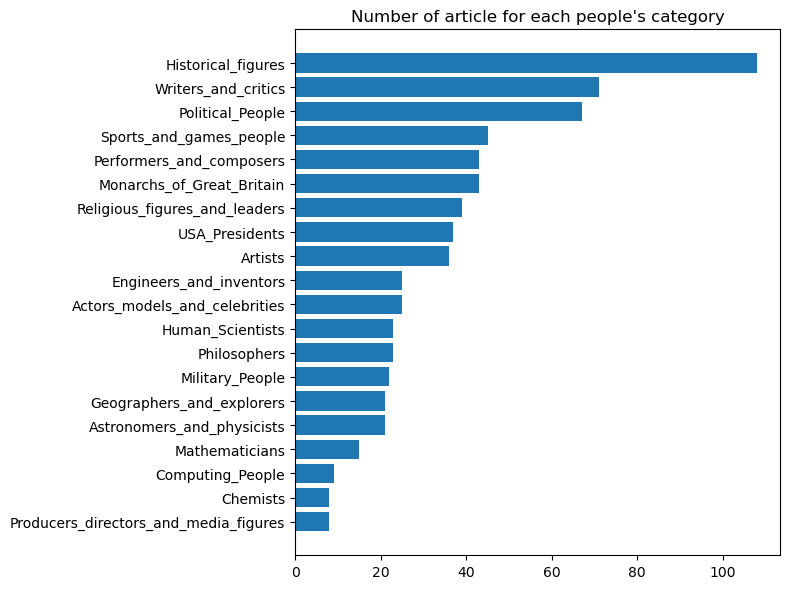

In [4]:
PATH_CATEGORIES = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv"

categories = pd.read_csv(PATH_CATEGORIES, header = 12, delimiter='\t',names=["article","categories"])

categories['article'] = categories['article'].apply(lambda x :(urllib.parse.unquote(x , encoding = 'utf-8'))) # Decode article names

people = categories[categories['categories'].str.contains('subject.People')].copy() # Dataset of people
people['categories'] = people['categories'].apply(lambda x : x[len('subject.People.'):]) # Remove useless string

counts = people.groupby('categories').count()
counts = counts.reset_index()
counts.columns = ["Name", "Count"]
counts=counts.sort_values("Count", ascending=True)

plt.figure(figsize=(8, 6))

plt.barh(counts["Name"], counts['Count'])
plt.title("Number of article for each people's category")
plt.xticks(rotation=0)
plt.tight_layout()

### Load Plain text into a dataframe 

In [5]:
plain_articles=load_plain_article()

# Analyze of the finished path

### Defying hubs, paths and internal path : without the beggining and finishing page

In [6]:
#Concatenate everything into a single character string
all_paths = finished_path['path'].apply(lambda x: x.split(';'))

#Keeping the start and end path and transforming into a dictionnary 
paths_flat = [path for sublist in all_paths for path in sublist]
paths_count = pd.Series(paths_flat).value_counts().to_dict()
paths_count.pop("<") # we remove the backward symbol


#Get rid of the first and last element
internal_paths = all_paths.apply(lambda x: x[1:-1] if len(x) > 2 else [])
internal_paths_flat = [path for sublist in internal_paths for path in sublist]
internal_paths_count = pd.Series(internal_paths_flat).value_counts().to_dict()
internal_paths_count.pop("<")

#evaluate the first and last page selection:
#df_start_end=pd.merge(df_paths_count,df_internal_paths_count,on="title", how="left")

print(paths_count)

print(internal_paths_count)

{'United_States': 8896, 'Europe': 4362, 'United_Kingdom': 3904, 'England': 3332, 'Earth': 3223, 'Africa': 2796, 'World_War_II': 2301, 'North_America': 1884, 'Germany': 1769, 'Animal': 1713, 'Human': 1642, 'Mammal': 1622, 'France': 1617, 'Computer': 1552, 'Science': 1497, 'English_language': 1430, 'Periodic_table': 1413, 'Brain': 1324, 'Atlantic_Ocean': 1324, 'Telephone': 1252, 'India': 1236, 'Bird': 1210, 'Viking': 1198, 'Agriculture': 1185, 'Plant': 1180, 'Asia': 1176, 'Asteroid': 1174, 'China': 1126, 'Christianity': 1097, 'Japan': 1086, 'United_Nations': 1064, 'Internet': 1047, 'Zebra': 1042, 'Theatre': 1038, 'Russia': 1019, 'Australia': 1003, 'Chemistry': 991, 'London': 976, 'Sun': 932, 'Canada': 922, 'South_America': 920, 'Water': 905, 'European_Union': 891, 'Adolf_Hitler': 883, 'Solar_System': 880, 'Italy': 867, 'President_of_the_United_States': 850, 'Physics': 848, 'Pacific_Ocean': 844, 'Chemical_element': 841, 'Computer_science': 834, 'Biology': 808, 'Mathematics': 805, 'Scotlan

In [7]:
unfinished_path.head()

,hashedIpAddress,timestamp,durationInSec,path_start,path_goal,rating
0,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
1,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
2,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
3,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
4,131600803df4895e,2011-02-07 17:42:37,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout


#### Same for the unfinished paths


In [8]:
all_paths_unfinished = unfinished_path['path_start'].apply(lambda x: x.split(';'))

#Keeping the start and end path and transforming into a dictionnary 
paths_flat_unfinished = [path for sublist in all_paths_unfinished for path in sublist]
paths_count_unfinished = pd.Series(paths_flat_unfinished).value_counts().to_dict()
paths_count_unfinished.pop("<") # we remove the backward symbol


#Get rid of the first and last element
internal_paths_unfinished= all_paths_unfinished.apply(lambda x: x[1:-1] if len(x) > 2 else [])
internal_paths_flat_unfinished = [path for sublist in internal_paths_unfinished for path in sublist]
internal_paths_count_unfinished = pd.Series(internal_paths_flat_unfinished).value_counts().to_dict()
internal_paths_count_unfinished.pop("<")

print(paths_count_unfinished)

print(internal_paths_count_unfinished)

{'United_States': 3553, 'United_Kingdom': 1424, 'Europe': 1249, 'England': 1226, 'Brain': 1100, 'Earth': 993, 'Pyramid': 961, 'Theatre': 932, 'Africa': 794, 'Asteroid': 768, 'Human': 761, 'Animal': 758, 'Mammal': 713, 'North_America': 710, 'France': 631, 'World_War_II': 630, 'English_language': 604, 'Agriculture': 561, 'India': 541, 'Plant': 528, 'Mexico': 517, 'Film': 474, 'Internet': 463, 'Germany': 457, 'Atlantic_Ocean': 435, 'London': 431, 'Science': 428, 'Christianity': 414, 'Computer': 409, 'Computer_science': 382, 'California': 380, 'Television': 374, 'Bird': 372, 'Culture': 370, 'Italy': 361, 'Batman': 360, 'Music': 359, 'United_Nations': 346, 'China': 338, 'Scotland': 335, 'Great_Britain': 328, 'Biology': 327, 'Russia': 323, 'Asia': 321, 'Japan': 319, 'Canada': 298, 'Australia': 297, 'Roman_Empire': 297, '20th_century': 292, 'Latin': 290, 'Pacific_Ocean': 290, 'Sport': 289, 'Fish': 288, 'British_Empire': 286, 'Technology': 285, 'Food': 280, 'New_York_City': 277, 'Sun': 273, 'E

### See if all articles of our dataset are used 

In [9]:
print('Number of articles used in finished path wikispeedia : %d'%(len(paths_count)))
print('Number of articles used in unfinished path wikispeedia : %d'%(len(paths_count_unfinished)))
print("Number of articles in the total Dataset : %d"%(len(plain_articles)))

if len(paths_count) != len(plain_articles):
    print("There are %d articles that are not used for the finished paths"%(len(plain_articles)-len(paths_count)))
else:
    print("All articles are used in the finished path of the users")

if len(paths_count) != len(plain_articles):
    print("There are %d articles that are not used for the unfinished paths"%(len(plain_articles)-len(paths_count_unfinished)))
else:
    print("All articles are used in the unfinished path of the users")

Number of articles used in finished path wikispeedia : 4169
Number of articles used in unfinished path wikispeedia : 4061
Number of articles in the total Dataset : 4604
There are 435 articles that are not used for the finished paths
There are 543 articles that are not used for the unfinished paths


## Graph of the access of used pages for finished paths

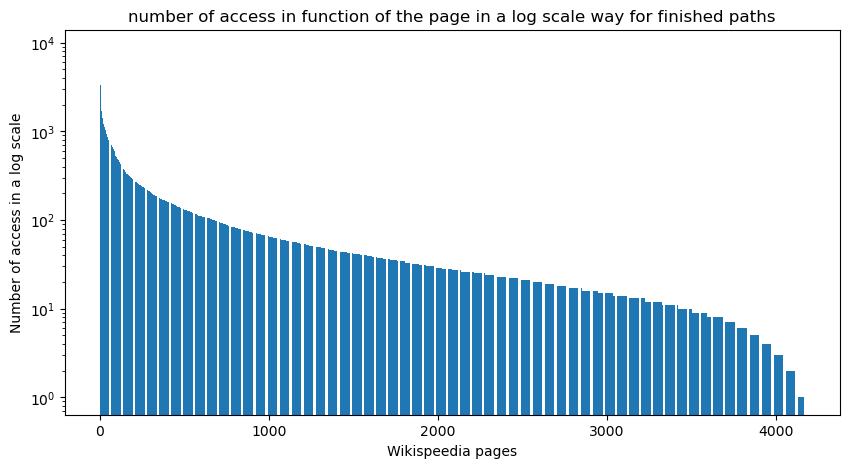

In [10]:
pages = list(paths_count.keys())
counts = list(paths_count.values())

# Reset the plot parameters to the default one
plt.rcdefaults()
plt.figure(figsize=(10, 5))
plt.bar(range(len(pages)), counts) 
plt.xlabel('Wikispeedia pages')
plt.ylabel('Number of access in a log scale')
plt.yscale('log')
plt.title('number of access in function of the page in a log scale way for finished paths')
plt.show()

### Same for the unfinished paths

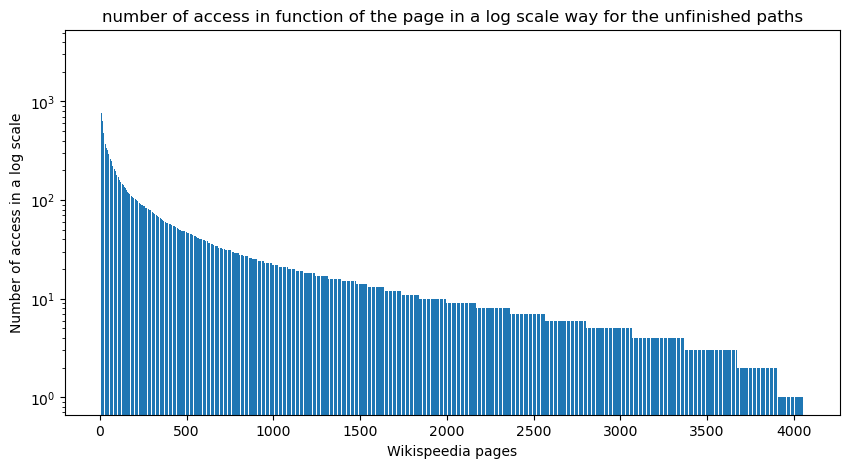

In [11]:
pages_unfinished = list(paths_count_unfinished.keys())
counts_unfinished = list(paths_count_unfinished.values())

plt.figure(figsize=(10, 5))
plt.bar(range(len(pages_unfinished)), counts_unfinished) 
plt.xlabel('Wikispeedia pages')
plt.ylabel('Number of access in a log scale')
plt.yscale('log')
plt.title('number of access in function of the page in a log scale way for the unfinished paths')
plt.show()

### Top 25 of hubs for finished and unfinished path

In [12]:
top_25_fin_hubs = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True)[:25])
top_25_unfin_hubs = dict(sorted(paths_count_unfinished.items(), key=lambda item: item[1], reverse=True)[:25])

C:\Users\wassi\AppData\Local\Temp\ipykernel_5764\3345679318.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(pages_fin, rotation=90)
C:\Users\wassi\AppData\Local\Temp\ipykernel_5764\3345679318.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(pages_unfin, rotation=90)


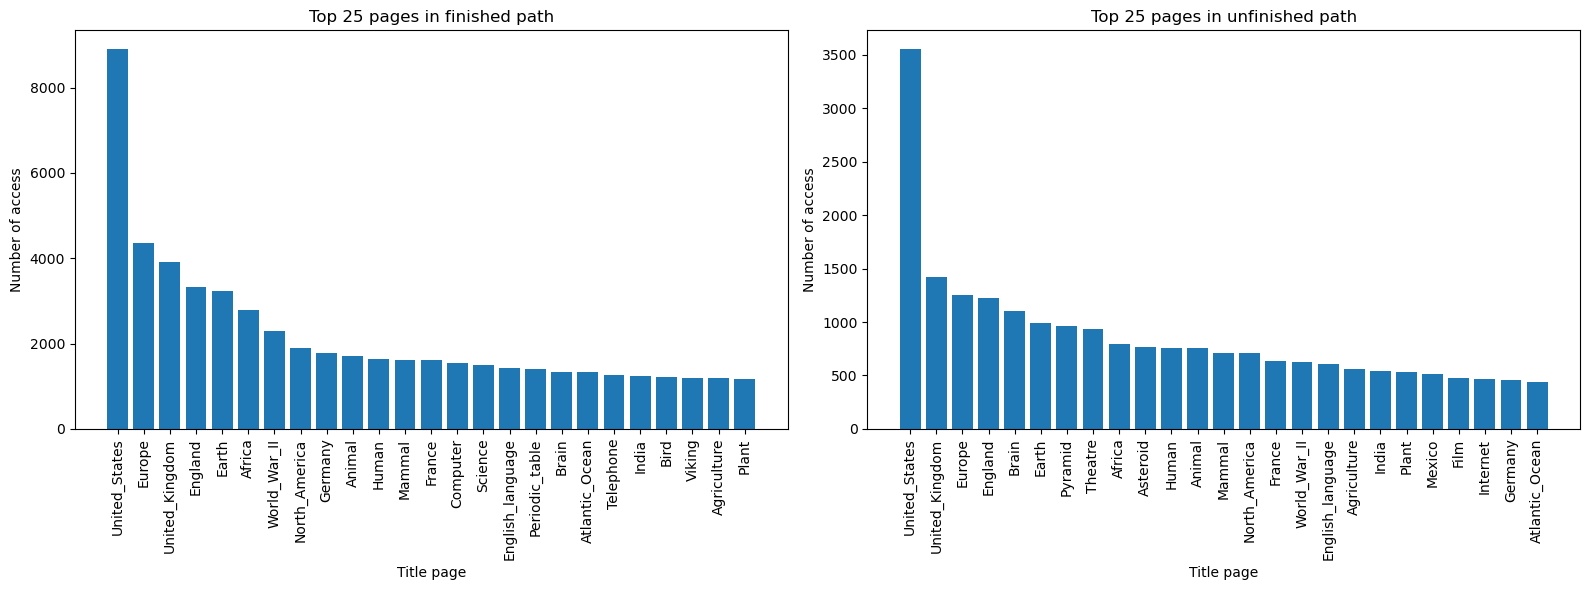

In [13]:
pages_fin = list(top_25_fin_hubs.keys())
counts_fin = list(top_25_fin_hubs.values())

pages_unfin = list(top_25_unfin_hubs.keys())
counts_unfin = list(top_25_unfin_hubs.values())

# plottings in a subplot way
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting on the top 25 pages in finished path
ax1.bar(pages_fin, counts_fin)
ax1.set_xlabel('Title page')
ax1.set_ylabel('Number of access')
ax1.set_xticklabels(pages_fin, rotation=90)
ax1.set_title('Top 25 pages in finished path')

# Plotting on the top 25 pages in unfinished path
ax2.bar(pages_unfin, counts_unfin)
ax2.set_xlabel('Title page')
ax2.set_ylabel('Number of access')
ax2.set_xticklabels(pages_unfin, rotation=90)
ax2.set_title('Top 25 pages in unfinished path')

plt.tight_layout()
plt.show()

We can see that a lots of hubs are used in both un/finished path but some are new (for exemple "Brain", "pyramid" and other ones), note that the number of acces in the unfinished path is lower than the finished path one (less data for unfinished paths data). 

### Political people representation from the finished pathing of users

In [14]:
#Hubs with all paths for finished one (including start and end articles)
all_hubs_fin = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True))

hubs_people_fin = {key: value for key, value in all_hubs_fin.items() if key in people['article'].tolist()}
hubs_political_people_fin = {key: value for key, value in hubs_people_fin.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

#Hubs with only the pathing for finished one (excluding start and end articles)
all_hubs_internal_fin = dict(sorted(internal_paths_count.items(), key=lambda item: item[1], reverse=True))

hubs_people_internal_fin = {key: value for key, value in all_hubs_internal_fin.items() if key in people['article'].tolist()}
hubs_political_people_internal_fin = {key: value for key, value in hubs_people_internal_fin.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

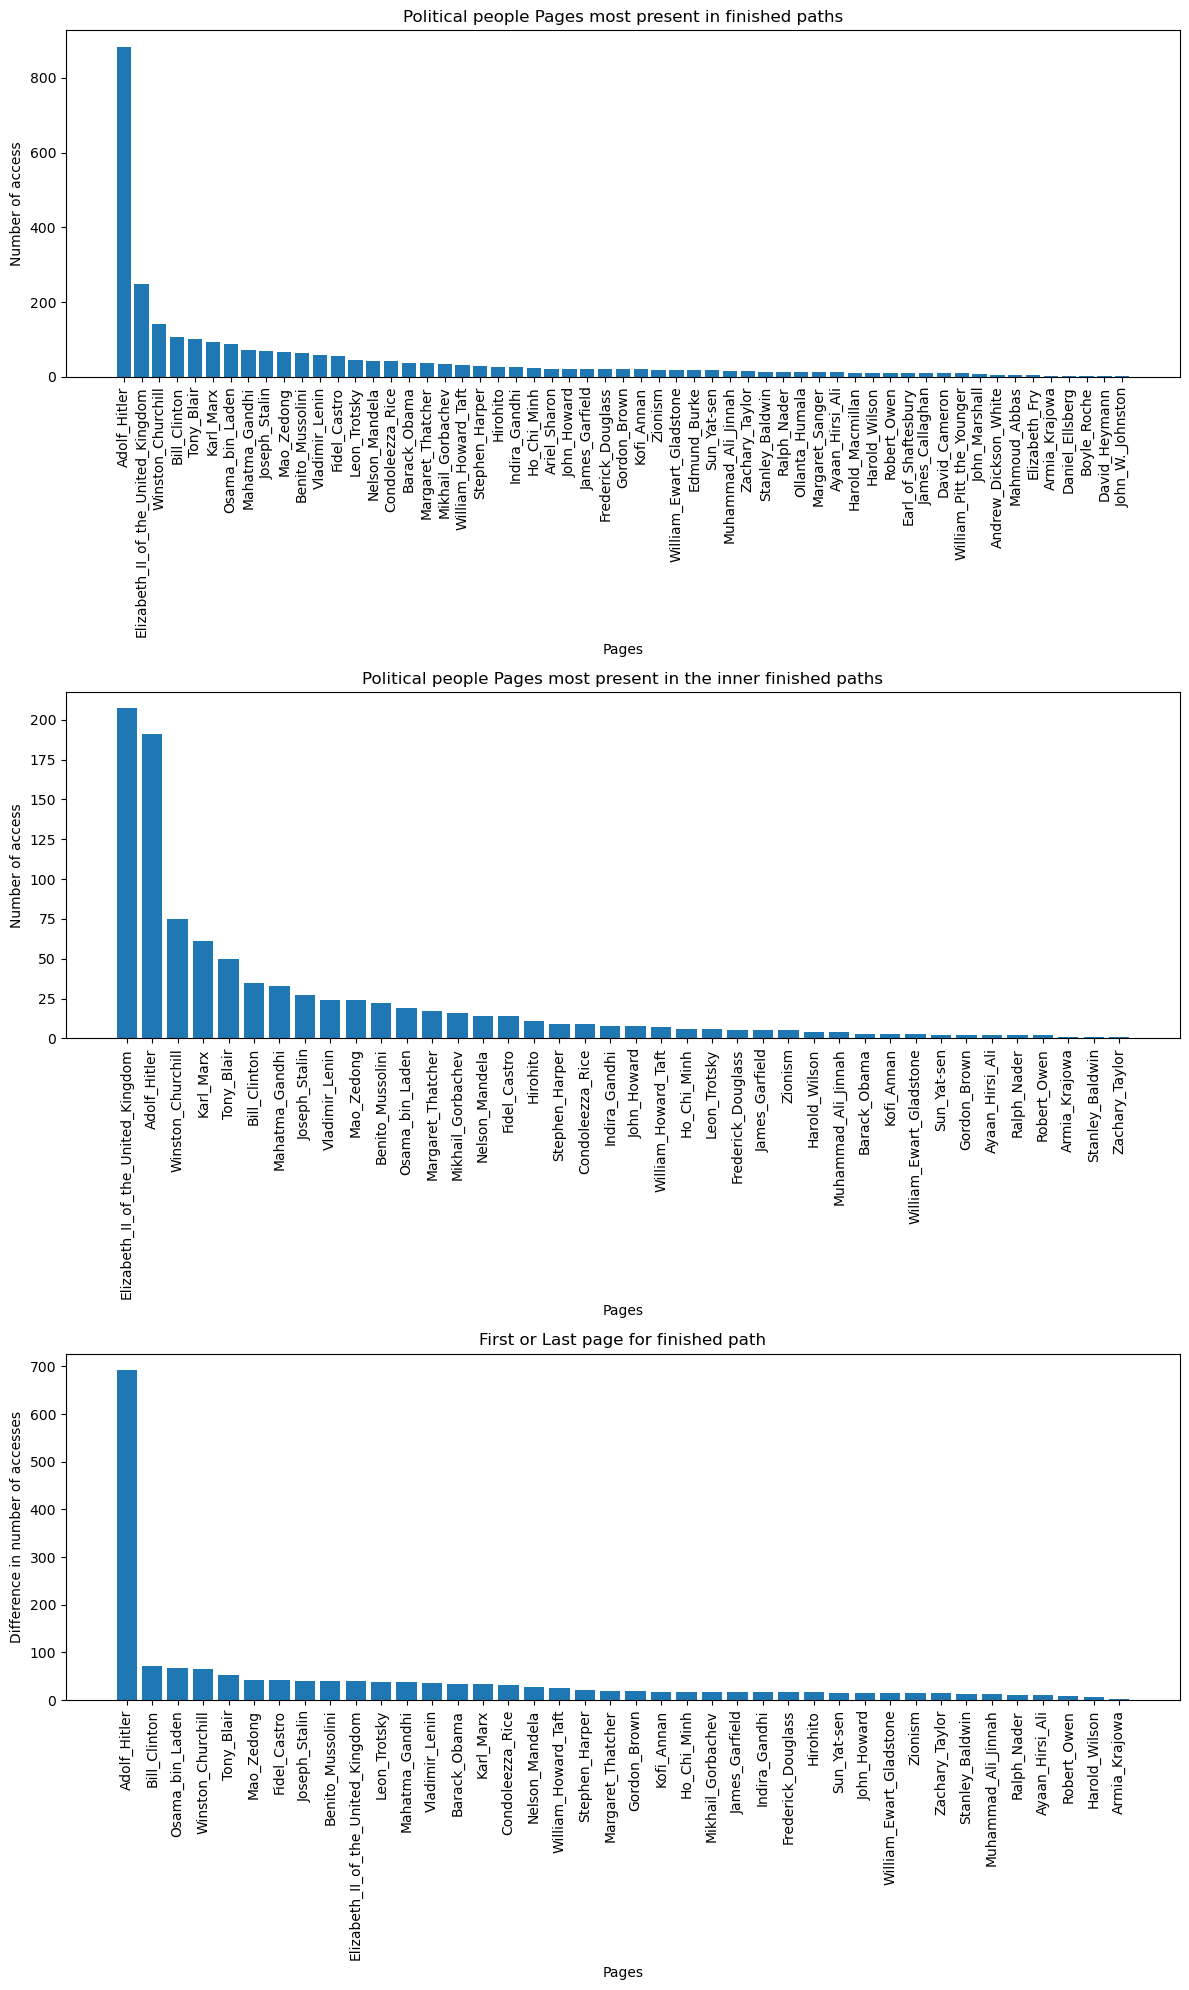

Median difference between the full path and the inner path for the finished paths:  20.0


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# preparation of the data

# full path
pages_fin = list(hubs_political_people_fin.keys())
counts_fin = list(hubs_political_people_fin.values())

# internal path
pages2_fin = list(hubs_political_people_internal_fin.keys())
counts2_fin = list(hubs_political_people_internal_fin.values())

# difference between the two sets 
common_keys_fin = set(hubs_political_people_fin.keys()) & set(hubs_political_people_internal_fin.keys())
diff_items_fin = {key: hubs_political_people_fin[key] - hubs_political_people_internal_fin[key] for key in common_keys_fin}
diff_items_fin = dict(sorted(diff_items_fin.items(), key=lambda item: item[1], reverse=True))

diff_values_fin = list(diff_items_fin.values())
median_diff_fin = np.median(diff_values_fin)

# subplots parts
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# Subplot 1: Political people Pages most present in finished paths
axes[0].bar(pages_fin, counts_fin)
axes[0].set_xlabel('Pages')
axes[0].set_ylabel('Number of access')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Political people Pages most present in finished paths')

# Subplot 2: Political people Pages most present in paths without start and end pages
axes[1].bar(pages2_fin, counts2_fin)
axes[1].set_xlabel('Pages')
axes[1].set_ylabel('Number of access')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('Political people Pages most present in the inner finished paths')

# Subplot 3: difference in access between the two sets
axes[2].bar(diff_items_fin.keys(), diff_items_fin.values())
axes[2].set_xlabel('Pages')
axes[2].set_ylabel('Difference in number of accesses')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_title("First or Last page for finished path")

plt.tight_layout()
plt.show()

print('Median difference between the full path and the inner path for the finished paths: ',median_diff_fin)


We can see that there is a strong influence of the human on the selection of the page for starting or ending the wikispeedia game 

### Political people representation from the unfinished pathing of users

In [16]:
#Hubs with all paths for finished one (including start and end articles)
all_hubs_unfin = dict(sorted(paths_count_unfinished.items(), key=lambda item: item[1], reverse=True))

hubs_people_unfin = {key: value for key, value in all_hubs_unfin.items() if key in people['article'].tolist()}
hubs_political_people_unfin = {key: value for key, value in hubs_people_unfin.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

#Hubs with only the pathing for finished one (excluding start and end articles)
all_hubs_internal_unfin = dict(sorted(internal_paths_count_unfinished.items(), key=lambda item: item[1], reverse=True))

hubs_people_internal_unfin = {key: value for key, value in all_hubs_internal_unfin.items() if key in people['article'].tolist()}
hubs_political_people_internal_unfin = {key: value for key, value in hubs_people_internal_unfin.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

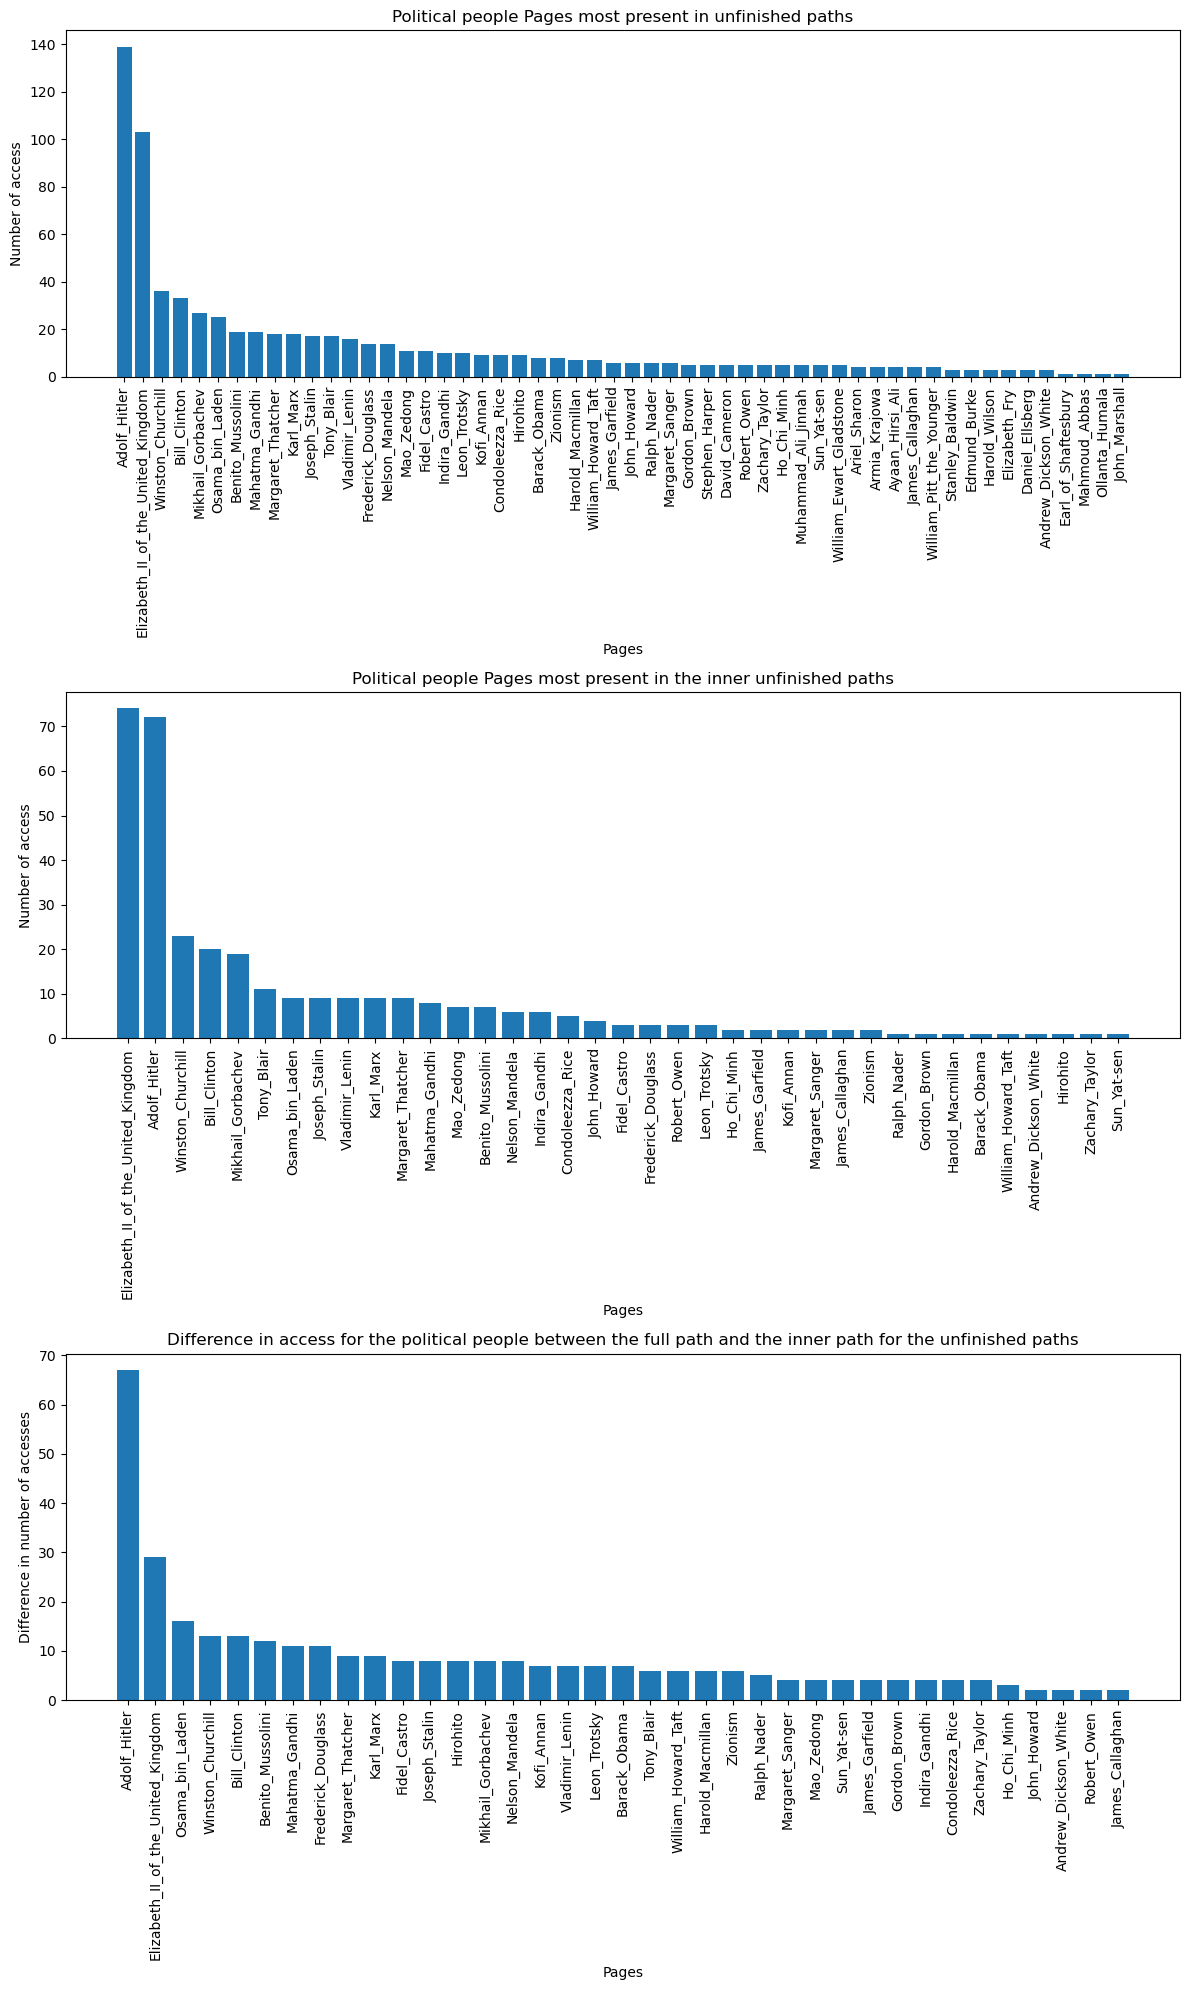

Median difference between the full path and the inner path for the unfinished paths:  7.0


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# preparation of the data

# full path
pages_unfin = list(hubs_political_people_unfin.keys())
counts_unfin = list(hubs_political_people_unfin.values())

# internal path
pages2_unfin = list(hubs_political_people_internal_unfin.keys())
counts2_unfin = list(hubs_political_people_internal_unfin.values())

# difference between the two sets 
common_keys_unfin = set(hubs_political_people_unfin.keys()) & set(hubs_political_people_internal_unfin.keys())
diff_items_unfin = {key: hubs_political_people_unfin[key] - hubs_political_people_internal_unfin[key] for key in common_keys_unfin}
diff_items_unfin = dict(sorted(diff_items_unfin.items(), key=lambda item: item[1], reverse=True))

diff_values_unfin = list(diff_items_unfin.values())
median_diff_unfin = np.median(diff_values_unfin)

# subplots parts
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# Subplot 1: Political people Pages most present in unfinished paths
axes[0].bar(pages_unfin, counts_unfin)
axes[0].set_xlabel('Pages')
axes[0].set_ylabel('Number of access')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Political people Pages most present in unfinished paths')

# Subplot 2: Political people Pages most present in paths without start and end pages
axes[1].bar(pages2_unfin, counts2_unfin)
axes[1].set_xlabel('Pages')
axes[1].set_ylabel('Number of access')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('Political people Pages most present in the inner unfinished paths')

# Subplot 3: difference in access between the two sets
axes[2].bar(diff_items_unfin.keys(), diff_items_unfin.values())
axes[2].set_xlabel('Pages')
axes[2].set_ylabel('Difference in number of accesses')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_title('Difference in access for the political people between the full path and the inner path for the unfinished paths')

plt.tight_layout()
plt.show()

print('Median difference between the full path and the inner path for the unfinished paths: ',median_diff_unfin)


### Difference of entry/finish between all articles in the finished and unfinished paths

C:\Users\wassi\AppData\Local\Temp\ipykernel_5764\1182884228.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(sorted_diff_fin.keys(), rotation=90)
C:\Users\wassi\AppData\Local\Temp\ipykernel_5764\1182884228.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(sorted_diff_unfin.keys(), rotation=90)


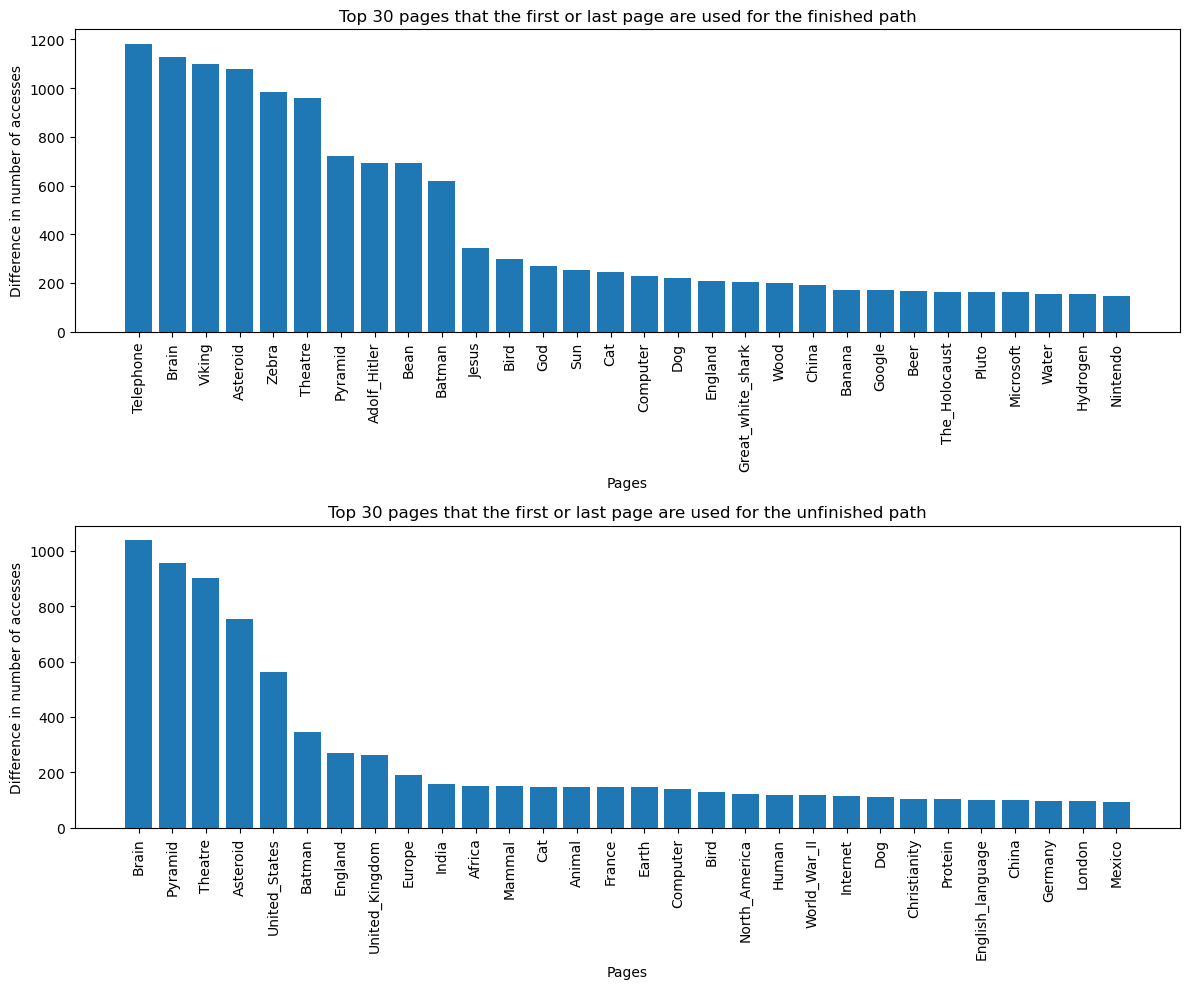

In [18]:
path_diff_dict_fin = {}
path_diff_dict_unfin = {}

#Making a dict that contains the diff in access between the paths and the internal paths
for key in paths_count:
    if key in internal_paths_count:
        path_diff_dict_fin[key] = paths_count[key] - internal_paths_count[key]

for key in paths_count_unfinished:
    if key in internal_paths_count_unfinished:
        path_diff_dict_unfin[key] = paths_count_unfinished[key] - internal_paths_count_unfinished[key]


sorted_diff_fin = sorted(path_diff_dict_fin.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_diff_fin = dict(sorted_diff_fin[0:30])
sorted_diff_unfin = sorted(path_diff_dict_unfin.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_diff_unfin = dict(sorted_diff_unfin[0:30])

# subplots parts: 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# first subplot for the finished path
ax1.bar(sorted_diff_fin.keys(), sorted_diff_fin.values())
ax1.set_xlabel('Pages')
ax1.set_ylabel('Difference in number of accesses')
ax1.set_xticklabels(sorted_diff_fin.keys(), rotation=90)
ax1.set_title('Top 30 pages that the first or last page are used for the finished path')

# second subplot for the unfinished path
ax2.bar(sorted_diff_unfin.keys(), sorted_diff_unfin.values())
ax2.set_xlabel('Pages')
ax2.set_ylabel('Difference in number of accesses')
ax2.set_xticklabels(sorted_diff_unfin.keys(), rotation=90)
ax2.set_title('Top 30 pages that the first or last page are used for the unfinished path')


plt.tight_layout()
plt.show()

## Classification of Political People, defined of political party and wikipedia description, classification by ourself

In [19]:
politicien = pd.read_csv('./political_affiliation.csv', delimiter= ';')
politicien.head(10)

,article,political_affiliation
0,Adolf_Hitler,Right
1,Andrew_Dickson_White,Right
2,Ariel_Sharon,Right
3,Armia_Krajowa,Right
4,Ayaan_Hirsi_Ali,Right
5,Barack_Obama,Left
6,Benito_Mussolini,Right
7,"Benjamin_Disraeli,_1st_Earl_of_Beaconsfield",Center
8,Bill_Clinton,Left
9,Boyle_Roche,Center


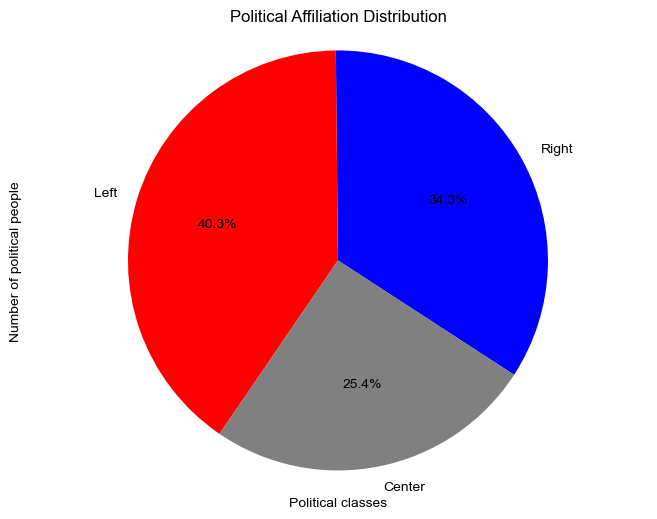

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

affiliation_counts = {"Right": 0, "Left": 0, "Center": 0}

for affiliation in politicien['political_affiliation']:
    if affiliation in affiliation_counts:
        affiliation_counts[affiliation] += 1

labels = list(affiliation_counts.keys())
sizes = list(affiliation_counts.values())
colors = ['blue', 'red', 'gray']

plt.figure(figsize=(8, 6))  
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-33)
plt.xlabel('Political classes')
plt.ylabel('Number of political people')
plt.title('Political Affiliation Distribution')
plt.axis('equal')  
sns.set_context("talk")  
sns.set_style("whitegrid")  
plt.show()


## Classification of all articles on the political bias present in the text 

This classification is explained in the README file and has been made in an other file. Here we are using the result of this Machine Learning prediction model.

In [21]:
bias = pd.read_csv('political_bias.csv')
bias.head(10)
bias["Bias"]= bias["Bias"].replace({0:"left", 1:"center", 2:"right"})

In [22]:
df_categories = categories.copy()
df_categories.head(20)

,article,categories
0,Áedán_mac_Gabráin,subject.People.Historical_figures
1,Åland,subject.Countries
2,Åland,subject.Geography.European_Geography.European_...
3,Édouard_Manet,subject.People.Artists
4,Éire,subject.Countries
5,Éire,subject.Geography.European_Geography.European_...
6,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...
7,Óengus_I_of_the_Picts,subject.People.Historical_figures
8,€2_commemorative_coins,subject.Business_Studies.Currency
9,10th_century,subject.History.General_history


In [23]:
import pandas as pd

# one hot encoding for all of the categories
df_categories['categories'] = df_categories['categories'].str.replace('subject.', '')
encoded_categories = df_categories['categories'].str.get_dummies(sep='.')

# concatenating the article names with the encoded categories
categories_encoded = pd.concat([df_categories['article'], encoded_categories], axis=1)

# combination of all of the categories for each article
categories_combined = categories_encoded.groupby('article').max().reset_index()

categories_combined.head()


,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_events,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# i test just to see for which columns is there a 1 for the article Åland
aland_row = categories_combined[categories_combined['article'] == 'Åland']

columns_with_1 = aland_row.iloc[:, 1:].eq(1).any()

column_names_with_1 = columns_with_1[columns_with_1].index.tolist()
print(column_names_with_1)


['Countries', 'European_Countries', 'European_Geography', 'Geography']


In [25]:
# now i'm merging the categories_combined df with the political bias df 

all_articles_with_bias_and_categories = pd.merge(categories_combined, bias, left_on = 'article', right_on = 'title', how = 'left')
all_articles_with_bias_and_categories = all_articles_with_bias_and_categories.drop('title', axis = 1)


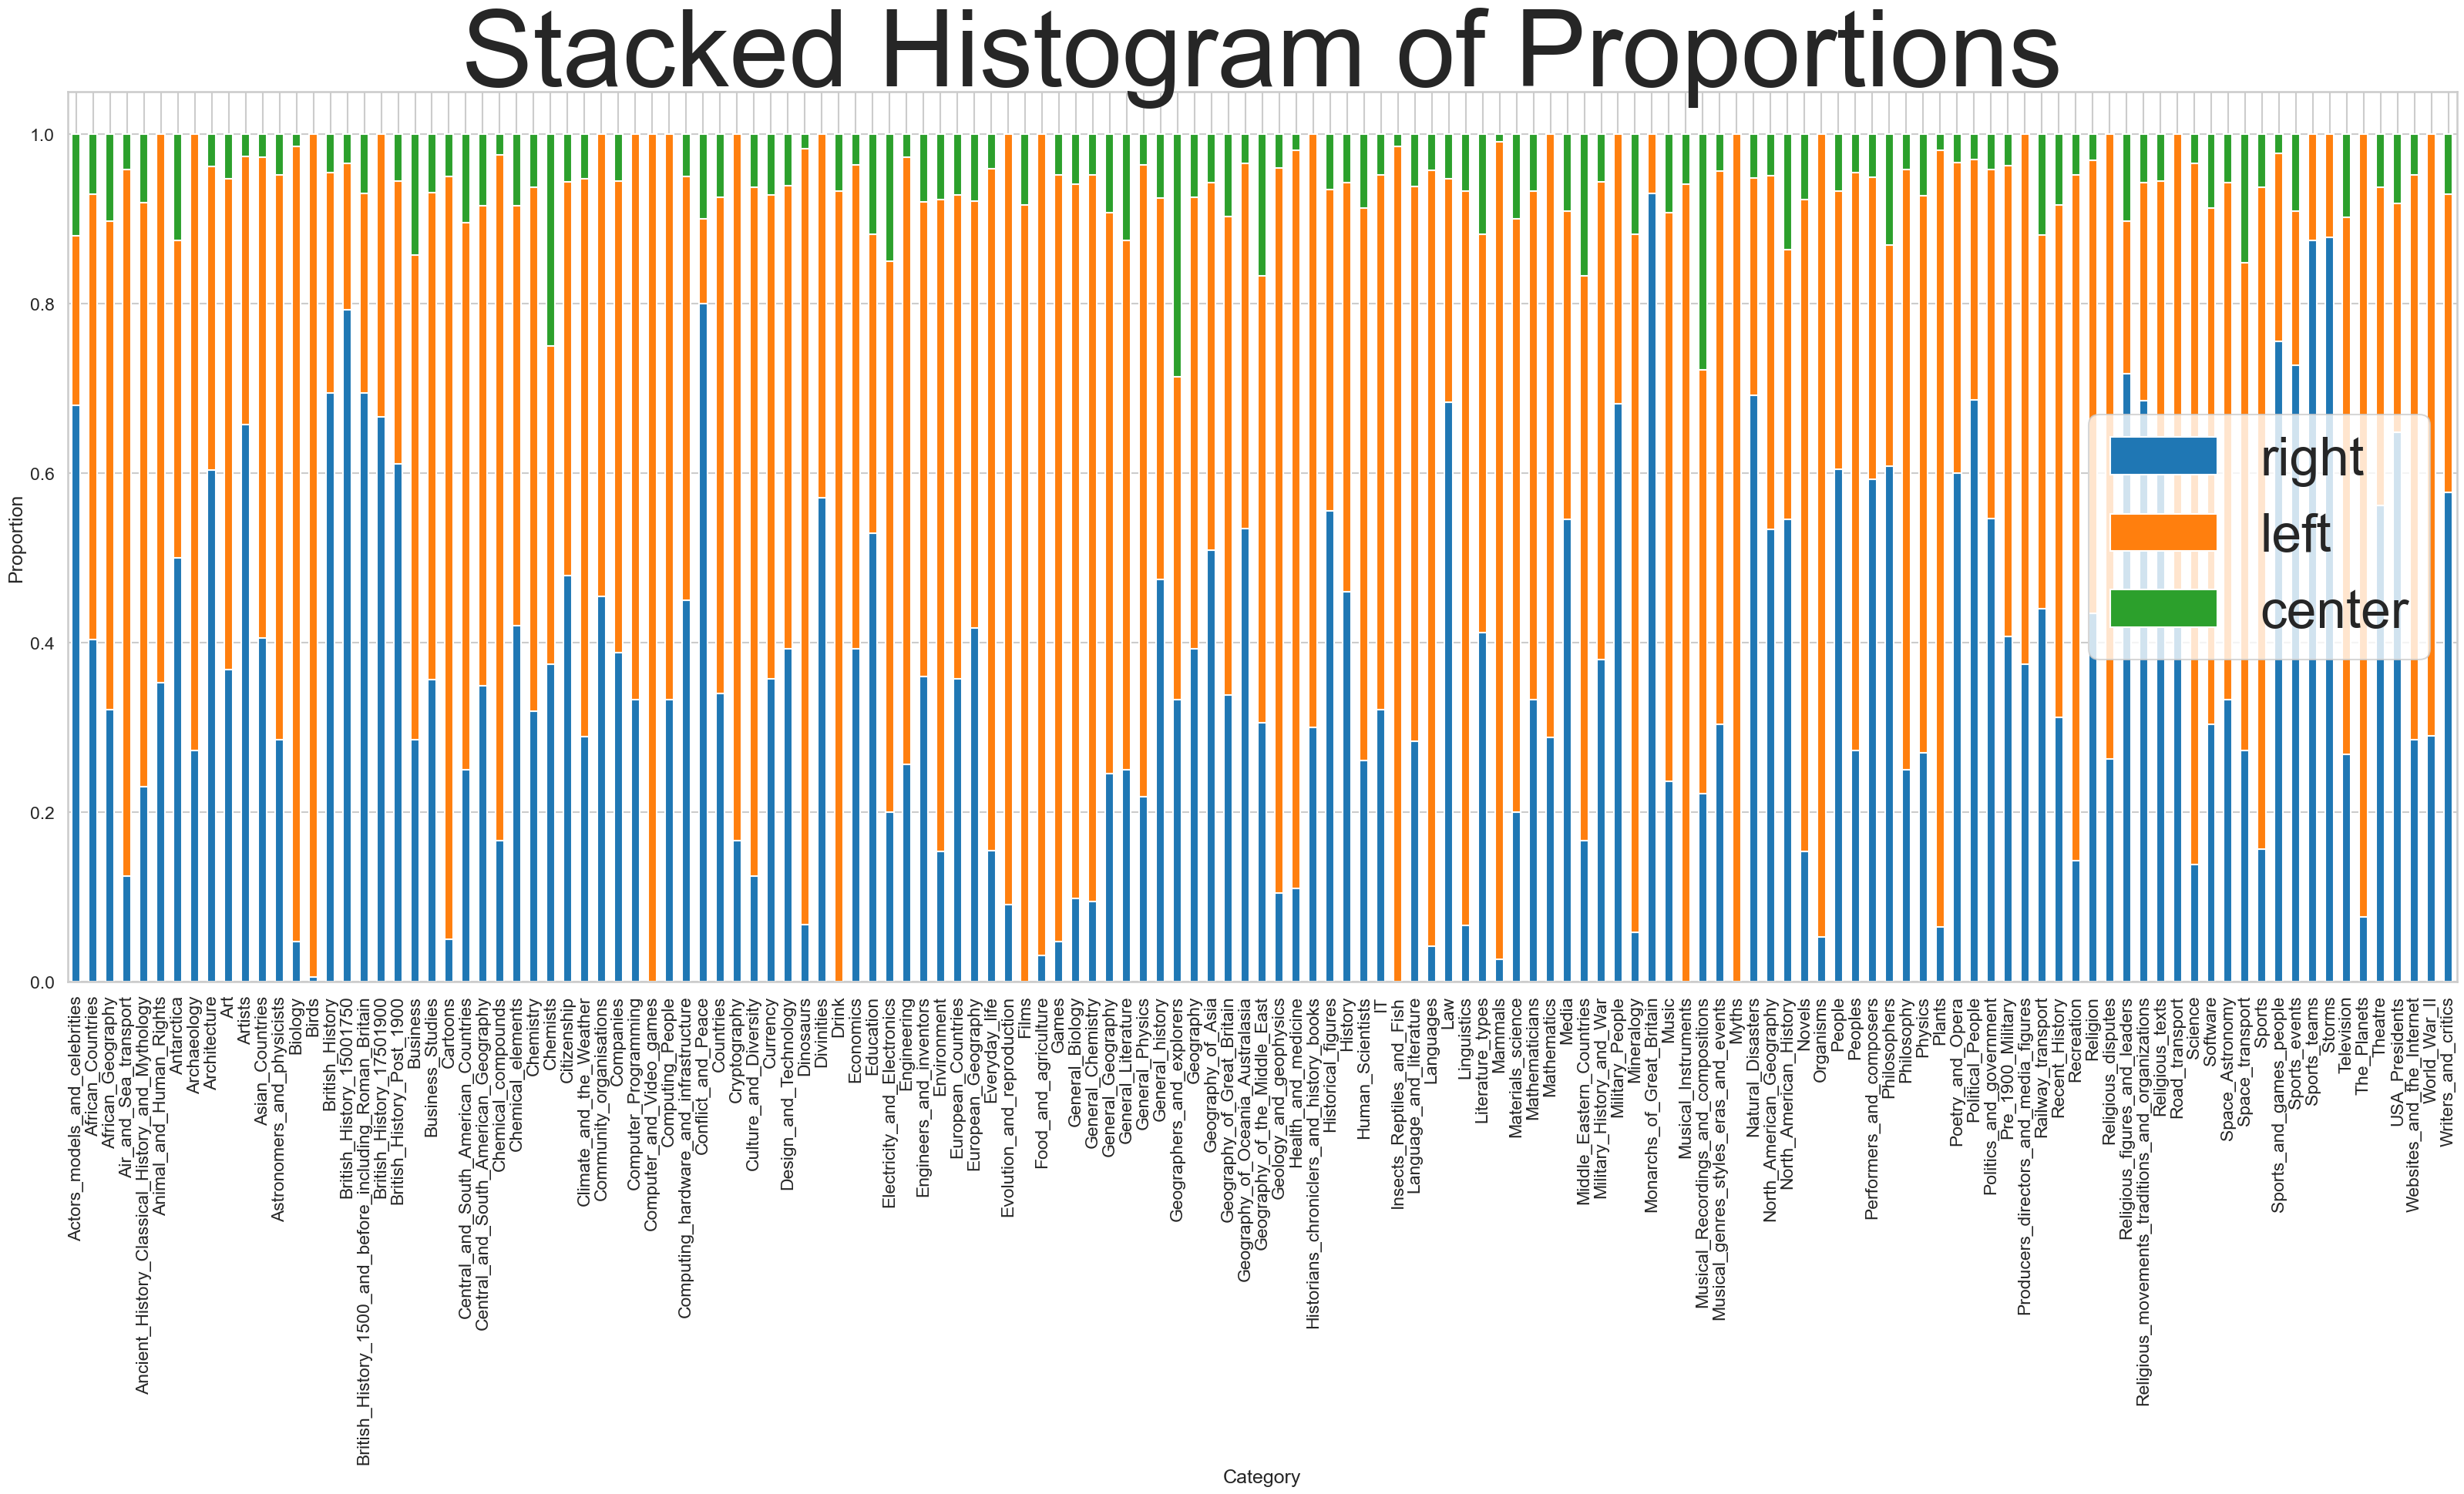

,right,left,center
count,141.000000,141.000000,141.000000
mean,26.957447,49.723404,4.432624
std,55.521279,110.368610,8.904497
min,0.000000,1.000000,0.000000
25%,5.000000,10.000000,1.000000
50%,11.000000,18.000000,2.000000
75%,29.000000,43.000000,4.000000
max,418.000000,914.000000,79.000000


<Figure size 640x480 with 0 Axes>

In [72]:
# Visualisation of proportions for each category

df = all_articles_with_bias_and_categories.copy()

right_df = df[df['Bias'] == 'right'].drop(columns=['article', 'Bias'])
right_df = right_df.sum()
right_df.name = 'right'
left_df = df[df['Bias'] == 'left'].drop(columns=['article', 'Bias'])
left_df = left_df.sum()
left_df.name ='left'
center_df = df[df['Bias'] == 'center'].drop(columns=['article', 'Bias'])
center_df = center_df.sum()
center_df.name = 'center'


plot_df = pd.merge(right_df, left_df, left_index=True, right_index=True, how='inner')
plot_df = pd.merge(plot_df, center_df, left_index=True, right_index=True, how='inner')
plot_df.head()

total_counts = plot_df.sum(axis=1)
proportions_df = plot_df.divide(total_counts, axis=0)

ax = proportions_df.plot(kind='bar', stacked=True, figsize=(40, 15))

plt.xlabel('Category')
plt.ylabel('Proportion')
plt.title('Stacked Histogram of Proportions', fontsize=100)
plt.legend(fontsize=50)
plt.show()
plt.tight_layout()


plot_df.describe()

                              right      left    center
Myths                      0.000000  1.000000  0.000000
Computer_and_Video_games   0.000000  1.000000  0.000000
Birds                      0.006211  0.993789  0.000000
Insects_Reptiles_and_Fish  0.000000  0.986111  0.013889
Food_and_agriculture       0.030928  0.969072  0.000000


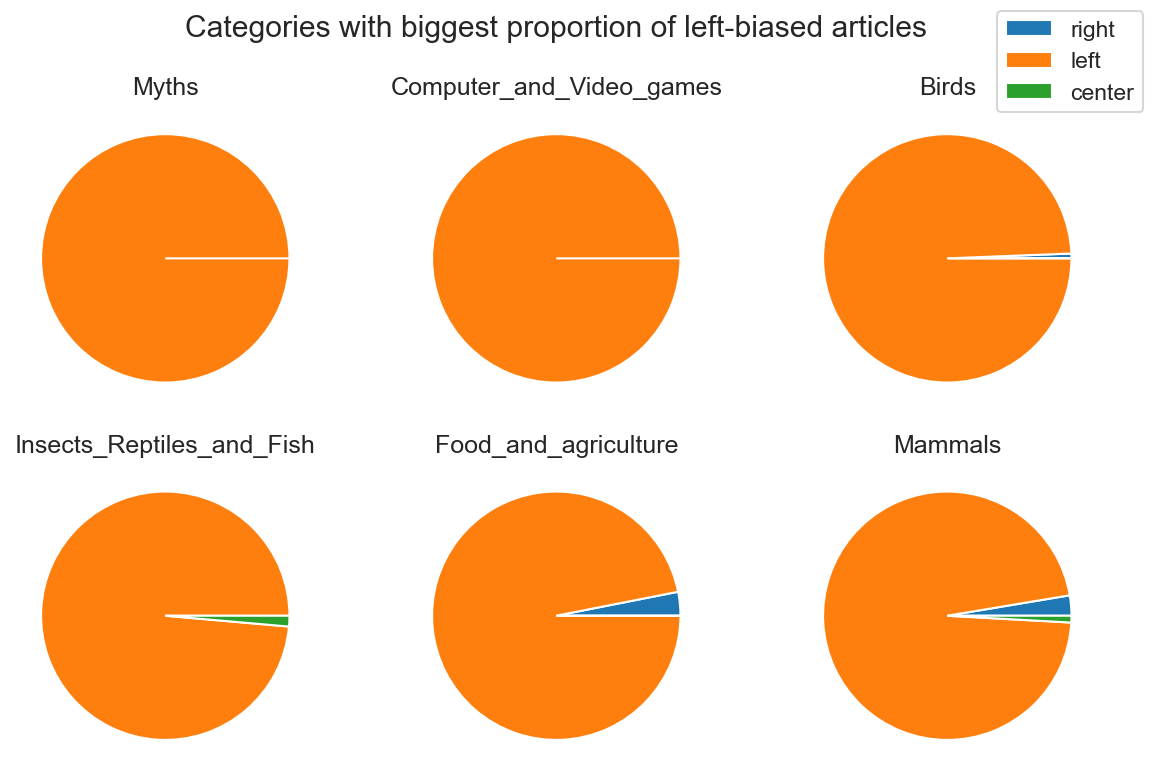

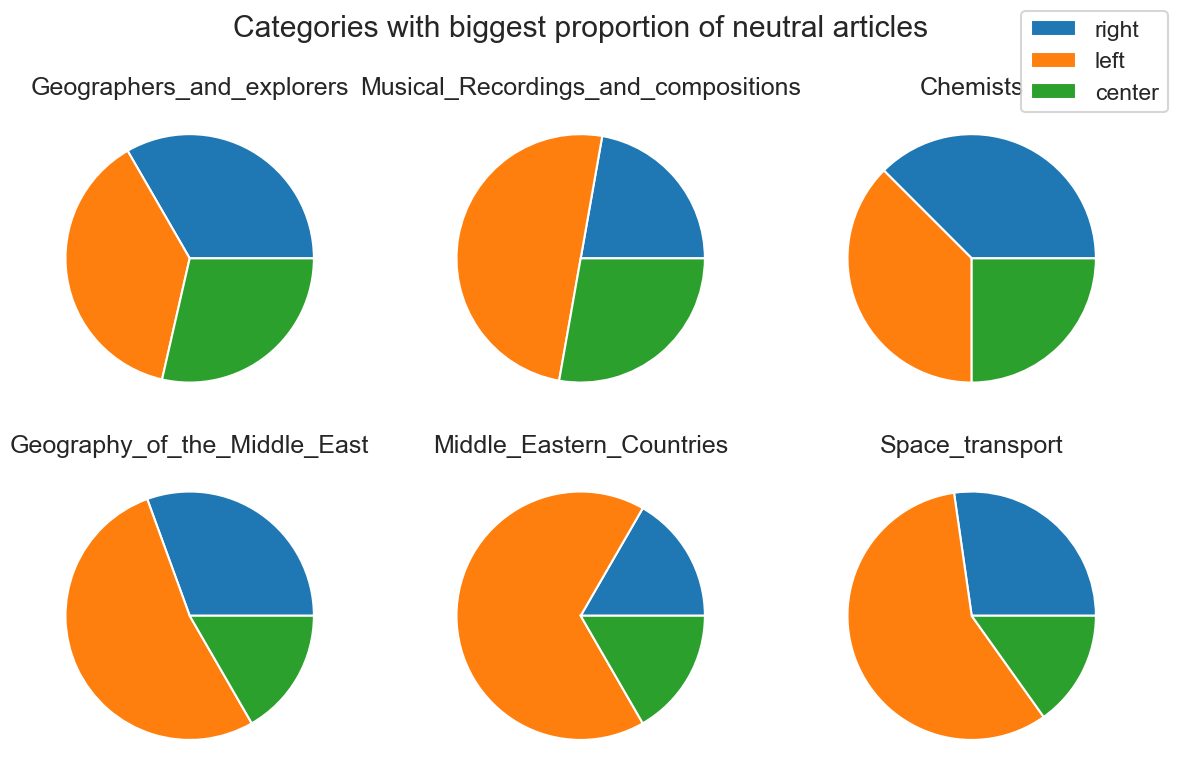

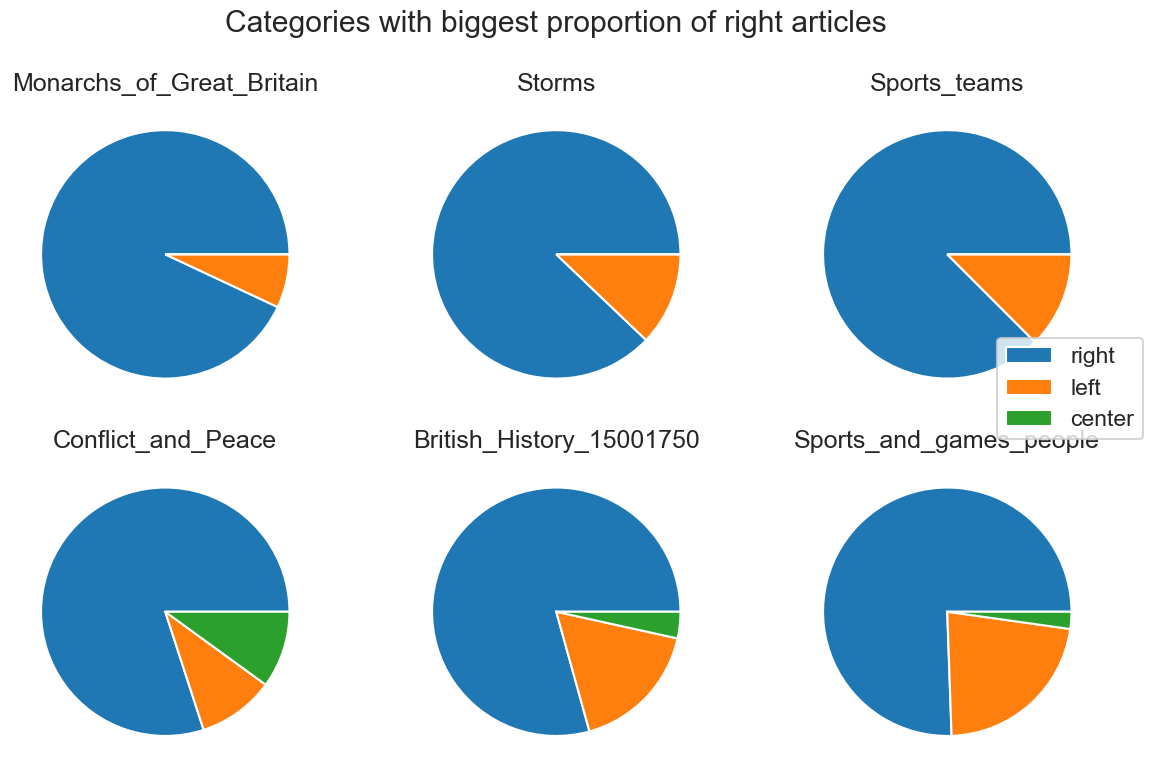

In [67]:
# Pie Charts

index_left = proportions_df.sort_values(by='left', ascending=False).index[:6]
fig, ax = plt.subplots(2,3,figsize=(12,8))
fig.suptitle("Categories with biggest proportion of left-biased articles")


for i,axe in enumerate(ax.flatten()) : 
    axe.pie(plot_df.loc[index_left[i]] )
    axe.set_title(index_left[i])
fig.legend(["right", "left", "center"]) 
plt.tight_layout()


index_center = proportions_df.sort_values(by='center', ascending=False).index[:6]
fig, ax = plt.subplots(2,3,figsize=(12,8))
fig.suptitle("Categories with biggest proportion of neutral articles")

for i,axe in enumerate(ax.flatten()) : 
    axe.pie(plot_df.loc[index_center[i]] )
    axe.set_title(index_center[i])
plt.tight_layout()
fig.legend(["right", "left", "center"]) 


index_right = proportions_df.sort_values(by='right', ascending=False).index[:6]
fig, ax = plt.subplots(2,3,figsize=(12,8))
fig.suptitle("Categories with biggest proportion of right articles")

for i,axe in enumerate(ax.flatten()) : 
    axe.pie(plot_df.loc[index_right[i]] )
    axe.set_title(index_right[i])
fig.legend(["right", "left", "center"], loc = "center right")
plt.tight_layout()

print(proportions_df.sort_values(by='left', ascending=False).head())

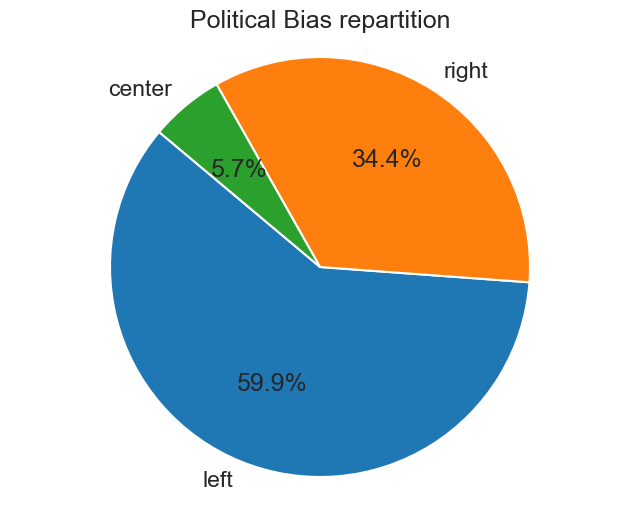

In [28]:
bias_counts = bias['Bias'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(bias_counts, labels=bias_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Political Bias repartition')
plt.axis('equal') 
plt.show()

In [29]:
categories = all_articles_with_bias_and_categories.drop(['article', 'Bias'], axis=1)
categories.head()

,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,Art,...,Sports_events,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### est-ce qu'on garde ce plot ???

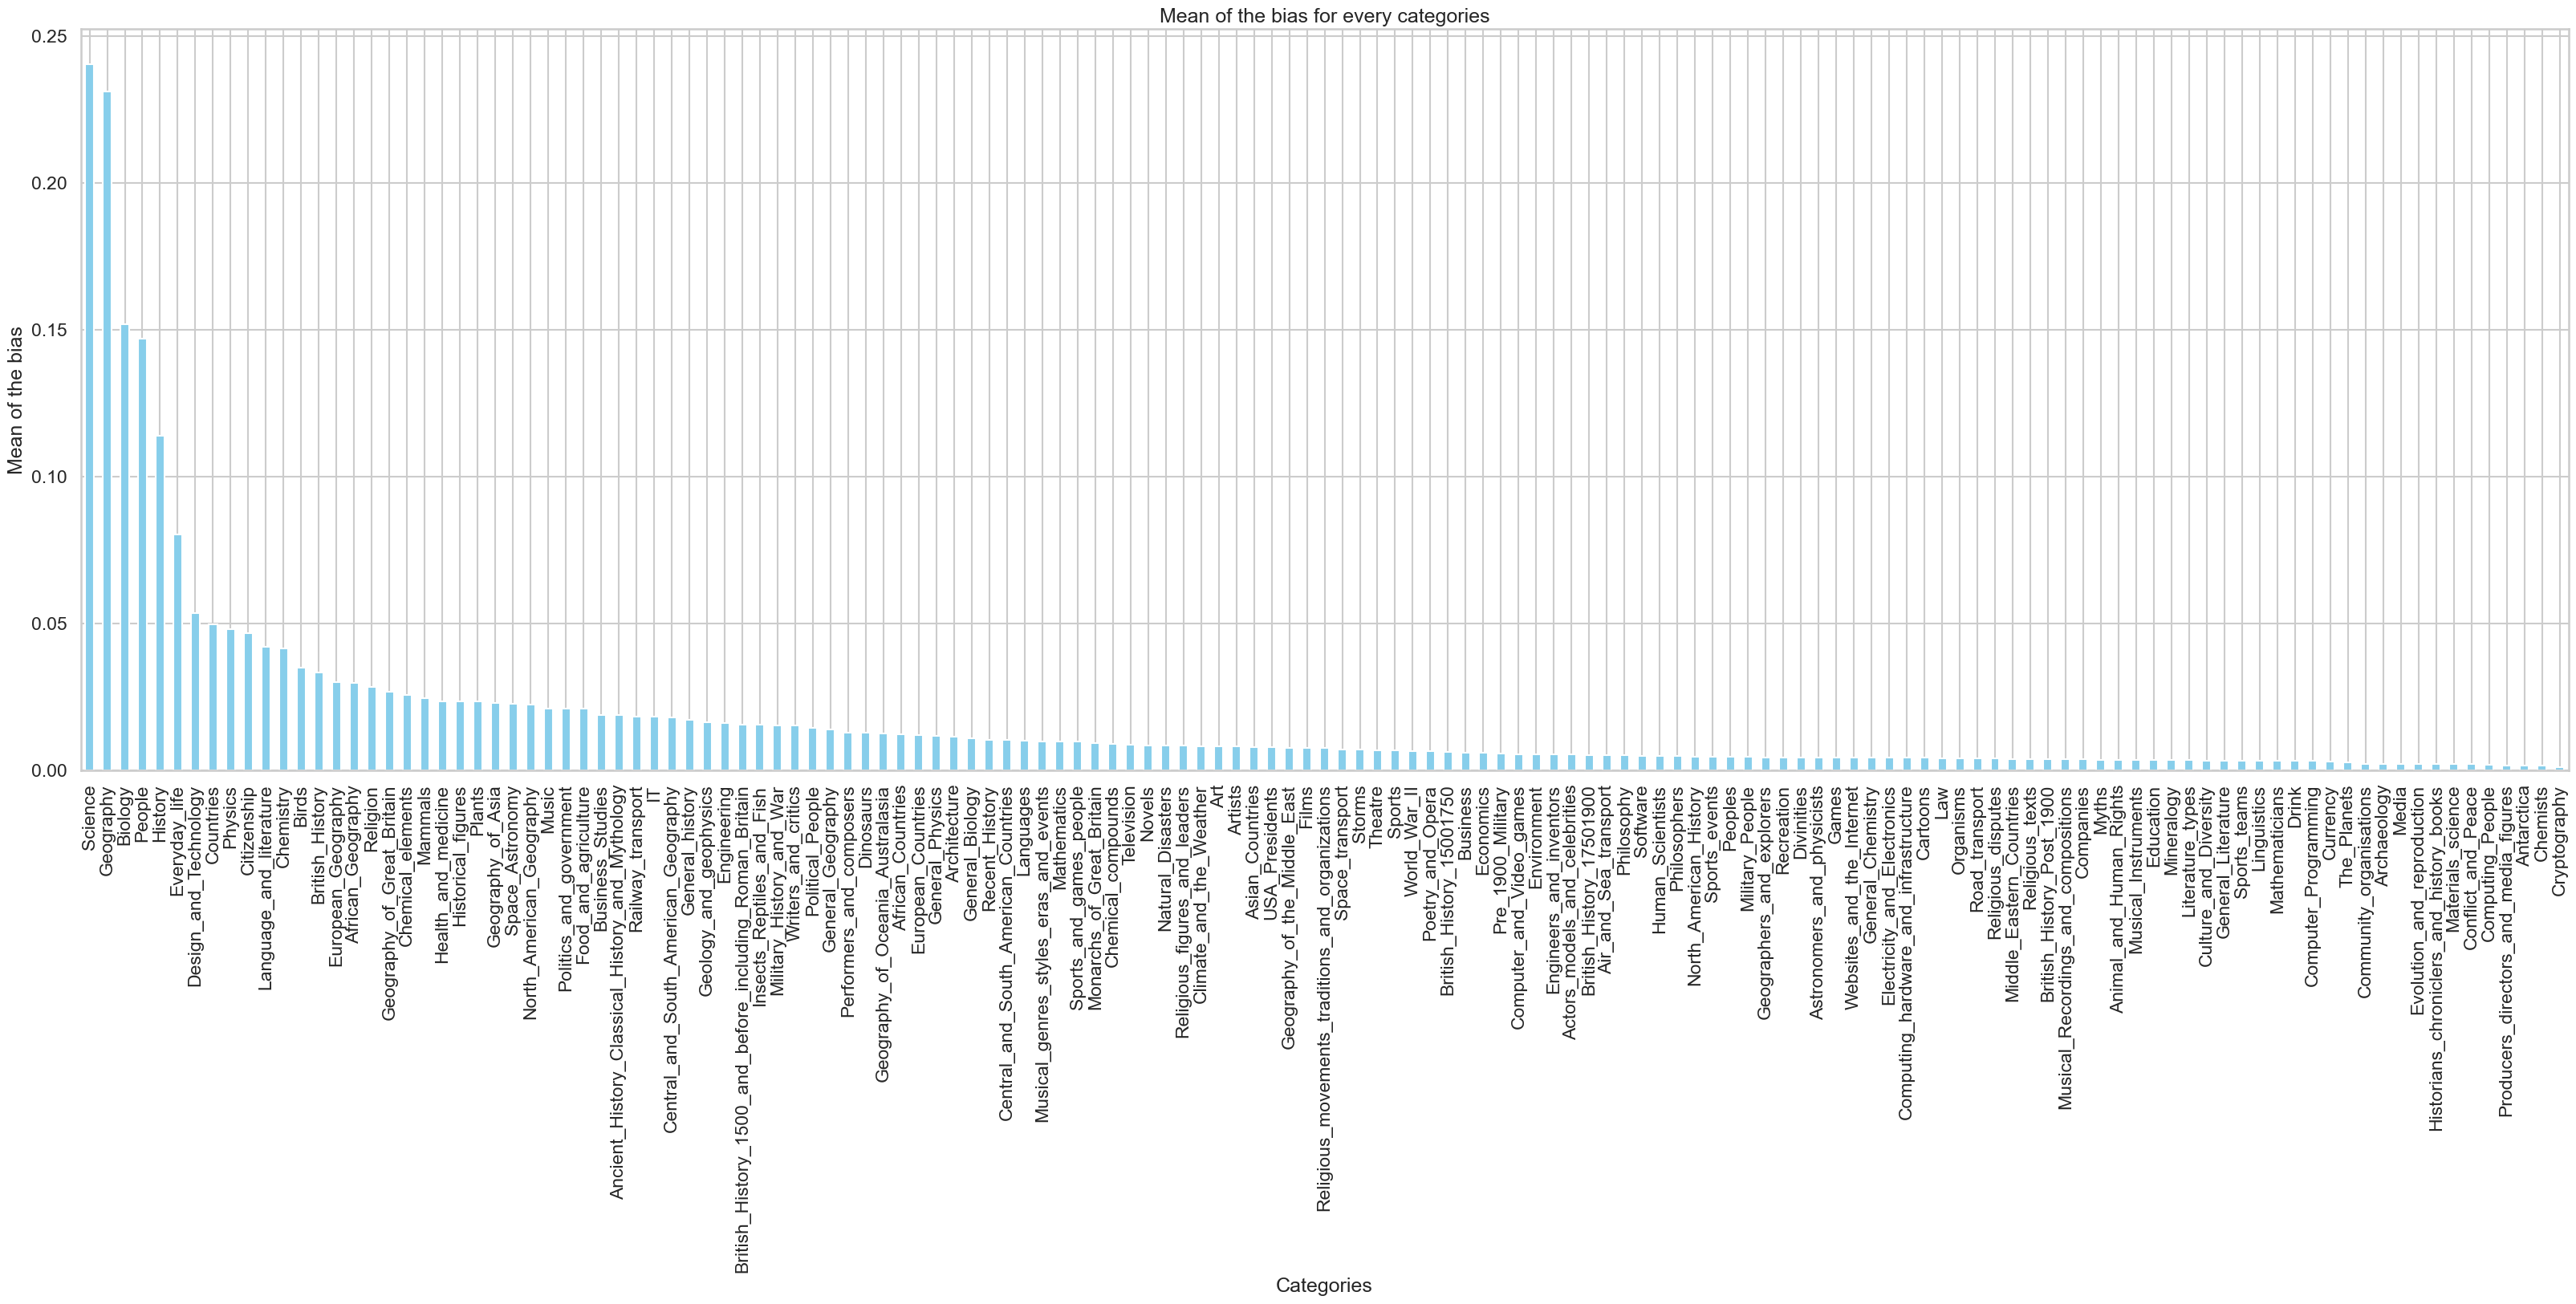

In [30]:
categories.mean().sort_values(ascending=False).plot(kind='bar', figsize=(40, 12), color='skyblue')
plt.title('Mean of the bias for every categories')
plt.xlabel('Categories')
plt.ylabel('Mean of the bias')
plt.xticks(rotation=90)
plt.show()

In [31]:
all_articles_with_bias_and_categories.head()

,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics,Bias
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,right
